# Intel PyTorch AMX BF16 Training
This code sample will quantize a ResNet50 model while using Intel's Extension for PyTorch (IPEX). The model will run inference with FP32 and INT8 precision, including static INT8 quantization and dynamic INT8 quantization. During Static Quantization, the model calibrated with the CIFAR10 dataset. The inference time will be compared, showcasing the speedup of INT8 Quantization.

## Environment Setup
Ensure the PyTorch kernel is activated before running this notebook.

## Imports, Dataset, Hyperparameters

In [9]:
import torch
import torchvision
from time import time
import matplotlib.pyplot as plt
import intel_extension_for_pytorch as ipex
from intel_extension_for_pytorch.quantization import prepare, convert

In [10]:
# Hyperparameters and constants
LR = 0.001
DOWNLOAD = True
DATA = 'datasets/cifar10/'
ITERS = 100
transform = torchvision.transforms.Compose([
torchvision.transforms.Resize((224, 224)),
torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=False,
        transform=transform,
        download=DOWNLOAD,
)
calibration_data_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=128
)

Files already downloaded and verified


## Get model from torchvision

In [11]:
data = torch.rand(1, 3, 224, 224)
model_fp32 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model_fp32.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Inference with FP32 model

In [14]:
start_time = time()
print("Inference with FP32")
for i in tqdm.tqdm(range(ITERS)):
    out = model_fp32(data)
end_time = time()

fp32_inference_time = (end_time - start_time) / ITERS

Inference with FP32


100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.89it/s]


## Static Quantization & Inference


In [15]:
# Acquire inference times for static quantization INT8 model 
qconfig_static = ipex.quantization.default_static_qconfig
# Alternatively, define your own qconfig:
#from torch.ao.quantization import MinMaxObserver, PerChannelMinMaxObserver, QConfig
#qconfig = QConfig(activation=MinMaxObserver.with_args(qscheme=torch.per_tensor_affine, dtype=torch.quint8),
#        weight=PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric))
prepared_model_static = prepare(model_fp32, qconfig_static, example_inputs=data, inplace=False)
print("Calibration with Static Quantization")
for (data, _) in tqdm.tqdm(calibration_data_loader):
    prepared_model_static(data)

converted_model_static = convert(prepared_model_static)
with torch.no_grad():
    traced_model_static = torch.jit.trace(converted_model_static, data)
    traced_model_static = torch.jit.freeze(traced_model_static)

# save the quantized static model 
traced_model_static.save("quantized_model_static.pt")

start_time = time()
print("Inference with Static Quantization")
for i in tqdm.tqdm(range(ITERS)):
    out = traced_model_static(data)
end_time = time()

int8_inference_time_static = (end_time - start_time) / ITERS


Calibration with Static Quantization


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [03:25<00:00,  2.60s/it]


Inference with Static Quantization


100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.70it/s]


## Dynamic Quantization & Inference

In [16]:
# Acquire inference times for dynamic quantization INT8 model
qconfig_dynamic = ipex.quantization.default_dynamic_qconfig
# Alternatively, define your own qconfig:
#from torch.ao.quantization import MinMaxObserver, PerChannelMinMaxObserver, QConfig
#qconfig = QConfig(activation=MinMaxObserver.with_args(qscheme=torch.per_tensor_affine, dtype=torch.quint8),
#        weight=PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric))
prepared_model_dynamic = prepare(model_fp32, qconfig_dynamic, example_inputs=data, inplace=False)

converted_model_dynamic = convert(prepared_model_dynamic)
with torch.no_grad():
    traced_model_dynamic = torch.jit.trace(converted_model_dynamic, data)
    traced_model_dynamic = torch.jit.freeze(traced_model_dynamic)

# save the quantized static model 
traced_model_dynamic.save("quantized_model_dynamic.pt")

start_time = time()
print("Inference with Dynamic Quantization")
for i in tqdm.tqdm(range(ITERS)):
    out = traced_model_dynamic(data)
end_time = time()

int8_inference_time_dynamic = (end_time - start_time) / ITERS



Inference with Dynamic Quantization


100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.03it/s]


## Summary of Results

Summary
FP32 inference time: 0.084
INT8 static quantization inference time: 0.012
INT8 dynamic quantization inference time: 0.100
Staic INT8 7.10X faster than FP32
Dynamic INT8 0.84X faster than FP32


<BarContainer object of 2 artists>

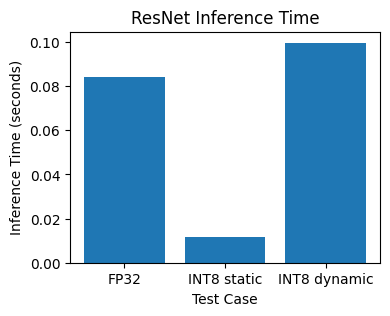

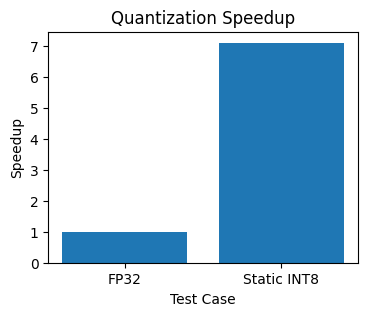

In [28]:
# Inference time results
print("Summary")
print("FP32 inference time: %.3f" %fp32_inference_time)
print("INT8 static quantization inference time: %.3f" %int8_inference_time_static)
print("INT8 dynamic quantization inference time: %.3f" %int8_inference_time_dynamic)

# Create bar chart with training time results
plt.figure(figsize=(4,3))
plt.title("ResNet Inference Time")
plt.xlabel("Test Case")
plt.ylabel("Inference Time (seconds)")
plt.bar(["FP32", "INT8 static", "INT8 dynamic"], [fp32_inference_time, int8_inference_time_static, int8_inference_time_dynamic])

# Calculate speedup when using quantization
speedup_from_fp32_static = fp32_inference_time / int8_inference_time_static
print("Staic INT8 %.2fX faster than FP32" %speedup_from_fp32_static)
speedup_from_fp32_dynamic = fp32_inference_time / int8_inference_time_dynamic
print("Dynamic INT8 %.2fX faster than FP32" %speedup_from_fp32_dynamic)


# Create bar chart with speedup results
plt.figure(figsize=(4,3))
plt.title("Quantization Speedup")
plt.xlabel("Test Case")
plt.ylabel("Speedup")
plt.bar(["FP32","Static INT8"], [1, speedup_from_fp32_static])

In [ ]:
print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')